In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import cv2
import os
import glob

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
#size of the image

SIZE =224

In [ ]:
#loading training data

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/sign/sign_data/train",
    image_size=(224, 224)
)

Found 1649 files belonging to 128 classes.


In [ ]:
# loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/sign/sign_data/test",
    seed=42,
    image_size=(224, 224)
)

Found 500 files belonging to 42 classes.


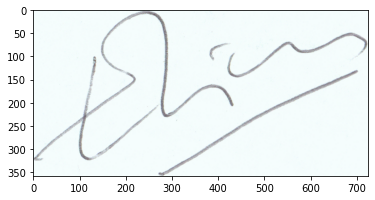

In [ ]:
#checking real image
import matplotlib.pyplot as plt
img = plt.imread('/content/gdrive/MyDrive/sign/sign_data/train/001/001_01.PNG')
plt.imshow(img)

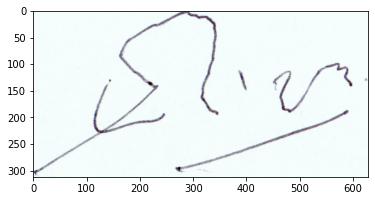

In [ ]:
#checking fake image
img1 = plt.imread('/content/gdrive/MyDrive/sign/sign_data/train/001_forg/0119001_01.png')
plt.imshow(img1)

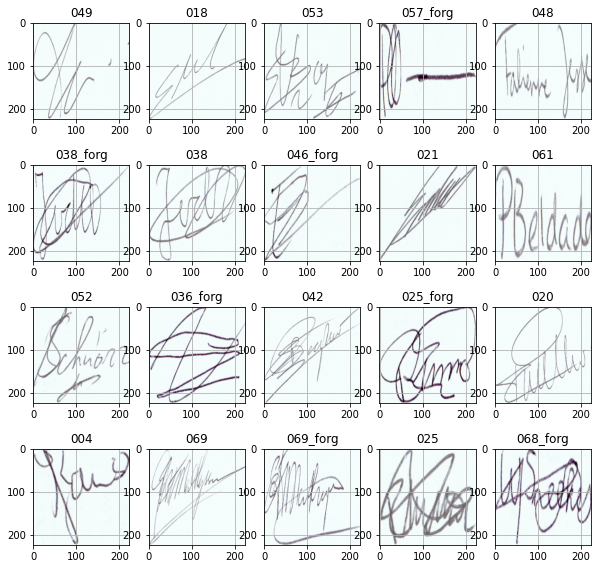

In [ ]:
#checking image in training dir

class_names = training_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i])
        plt.title(class_names[labels[i]])
        plt.grid(True)

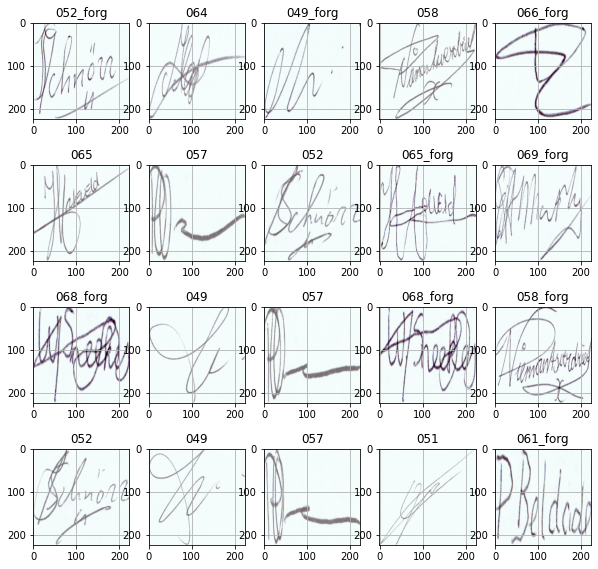

In [ ]:
#checking image in testing dir
class_names = testing_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in testing_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i])
        plt.title(class_names[labels[i]])
        plt.grid(True)

In [ ]:
#saving images in numpy array

import cv2
import os
import glob

train_data = []
train_labels = []

for per in os.listdir("/content/gdrive/MyDrive/sign/sign_data/train/"):
    for data in glob.glob('/content/gdrive/MyDrive/sign/sign_data/train/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))
train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

#Test Data
test_data = []
test_labels = []
for per in os.listdir('/content/gdrive/MyDrive/sign/sign_data/test/'):
    for data in glob.glob('/content/gdrive/MyDrive/sign/sign_data/test/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))
test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

For use of categorical entropy loss we need to configure data

In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [ ]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
train_data.shape

(1649, 1, 224, 224, 3)

In [ ]:
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)

In [ ]:
train_data.shape


(1649, 224, 224, 3)

In [ ]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

In [ ]:
# creating cnn model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix as CM
from keras.optimizers import Adam

network = Sequential()

network.add(Conv2D(64,(3,3),input_shape=(SIZE,SIZE,3),activation='relu'))
network.add(MaxPooling2D(3,3))
network.add(Conv2D(32,(3,3),activation='relu'))
network.add(MaxPooling2D(2,2))
network.add(Conv2D(32,(3,3),activation='relu'))
network.add(MaxPooling2D(2,2))
network.add(Flatten())
network.add(Dense(128,activation = 'relu'))
network.add(Dropout(rate=0.3))
network.add(Dense(2,activation = 'softmax'))

network.compile(optimizer=keras.optimizers.Adam(),loss="categorical_crossentropy",metrics=["accuracy"])
network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 32)      

In [1]:
#model Training

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1)

early_stop=[earlyStopping]


EPOCHS = 100
BS = 30
progress = network.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)

Epoch 1/100
39/39 [==============================] - 93s 2s/step - loss: 0.6587 - accuracy: 0.5997 - val_loss: 0.5044 - val_accuracy: 0.8566
Epoch 2/100
39/39 [==============================] - 87s 2s/step - loss: 0.3130 - accuracy: 0.8839 - val_loss: 0.3029 - val_accuracy: 0.8626
Epoch 3/100
39/39 [==============================] - 88s 2s/step - loss: 0.2418 - accuracy: 0.9220 - val_loss: 0.2371 - val_accuracy: 0.9192
Epoch 4/100
39/39 [==============================] - 85s 2s/step - loss: 0.1920 - accuracy: 0.9289 - val_loss: 0.1858 - val_accuracy: 0.9091
Epoch 5/100
39/39 [==============================] - 88s 2s/step - loss: 0.1460 - accuracy: 0.9445 - val_loss: 0.1540 - val_accuracy: 0.9293
Epoch 6/100
39/39 [==============================] - 85s 2s/step - loss: 0.1289 - accuracy: 0.9489 - val_loss: 0.2642 - val_accuracy: 0.9172
Epoch 7/100
39/39 [==============================] - 88s 2s/step - loss: 0.0957 - accuracy: 0.9636 - val_loss: 0.1393 - val_accuracy: 0.9354
Epoch 8/100
3

In [ ]:
cd /content/gdrive/MyDrive/sign

/content/gdrive/MyDrive/sign


In [ ]:
network.save("model99_57_val_96.hdf5")

In [ ]:
network.save("modelacc99_57val_96_5.h5")

In [ ]:
# accuracy plots

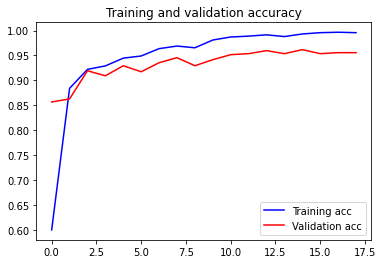

In [ ]:
acc = progress.history['accuracy']
val_acc = progress.history['val_accuracy']
loss = progress.history['loss']
val_loss = progress.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.show()

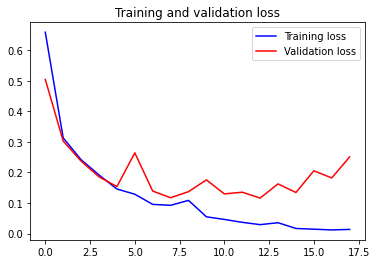

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
pred = network.predict(test_data)

16/16 [==============================] - 11s 670ms/step


In [ ]:
pred

array([[9.04736084e-14, 9.99999940e-01],
       [9.88528877e-12, 9.99999940e-01],
       [4.79359445e-21, 9.99999940e-01],
       [1.75550987e-04, 9.99824524e-01],
       [9.99845982e-01, 1.54003777e-04],
       [2.95350001e-05, 9.99970376e-01],
       [9.99911606e-01, 8.82810200e-05],
       [9.99556124e-01, 4.43814555e-04],
       [9.98527110e-01, 1.47276989e-03],
       [1.69013678e-10, 9.99999940e-01],
       [1.10536307e-15, 9.99999940e-01],
       [9.99837875e-01, 1.62104698e-04],
       [9.99812126e-01, 1.87943966e-04],
       [3.62335436e-06, 9.99996364e-01],
       [4.96578310e-27, 9.99999940e-01],
       [3.41371931e-11, 9.99999940e-01],
       [9.99802351e-01, 1.97560075e-04],
       [1.06211957e-07, 9.99999821e-01],
       [9.98955011e-01, 1.04496221e-03],
       [3.68002728e-17, 9.99999940e-01],
       [9.99937952e-01, 6.20316860e-05],
       [9.99596775e-01, 4.03208542e-04],
       [9.99664664e-01, 3.35359102e-04],
       [9.99878824e-01, 1.21074554e-04],
       [9.995451

In [ ]:
predict =np.argmax(pred,axis=1)

In [ ]:
# confusion matrix

In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm=confusion_matrix(test_labels,predict )
cm

array([[248,   4],
       [  1, 247]])

In [ ]:
# True Negatives are denoted by 'TN'
# Actual 'O' values which are classified correctly
TN = cm[0,0]

# True Positives are denoted by 'TP'
# Actual '1' values which are classified correctly
TP = cm[1,1]

# False Positives are denoted by 'FP'
# it is the type 1 error
# Actual 'O' values which are classified wrongly as '1'
FP = cm[0,1]

# False Negatives are denoted by 'FN'
# it is the type 2 error
# Actual '1' values which are classified wrongly as '0'
FN = cm[1,0]

In [ ]:
# calculate the precision value
precision = TP / (TP+FP)

# print the value
precision

0.9840637450199203

In [ ]:
recall = TP / (TP+FN)

# print the value
recall

0.9959677419354839

In [ ]:
# calculate the specificity value
specificity = TN / (TN+FP)

# print the value
specificity

0.9841269841269841

In [ ]:
# calculate the f1_score
f1_score = 2*((precision*recall)/(precision+recall))

# print the f1_score
f1_score

0.9899799599198397

In [ ]:
# calculate the accuracy
accuracy = (TN+TP) / (TN+FP+FN+TP)

# print the accuracy
accuracy

0.99

In [ ]:
# classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,predict))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       252
           1       0.98      1.00      0.99       248

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



In [ ]:
#chen kappa nad roc_auc

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
cohen_kappa_score(test_labels,predict)

0.9800006399795207

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(test_labels,predict)

0.9900473630312341